In [2]:
import eventregistry as ER
import re
import numpy as np
import datetime
from geopy.geocoders import Nominatim
import urllib.parse, urllib.request, json

In [46]:
wikifier_key = ""
er_key = ""

In [3]:
place_number = [0,0,0,0]
plac_dic = {
    'City':0,
    'Country':1, 
    'State':2, 
    'Village':3
}

def CallWikifier(text, dissaster, lang="en", threshold=0.8):
    places = ['City', 'Country', 'State', 'Village']
    geolocator = Nominatim(user_agent="name")
    
    file = open('places.txt', 'a', encoding="utf-8")
    # Prepare the URL.
    data = urllib.parse.urlencode([
        ("text", text), ("lang", lang),
        ("userKey", wikifier_key),
        ("pageRankSqThreshold", "%g" % threshold), ("applyPageRankSqThreshold", "true"),
        ("nTopDfValuesToIgnore", "200"), ("nWordsToIgnoreFromList", "200"),
        ("wikiDataClasses", "true"), ("wikiDataClassIds", "false"),
        ("support", "false"), ("ranges", "false"), ("minLinkFrequency", "2"),
        ("includeCosines", "false"), ("maxMentionEntropy", "3")
        ])
    url = "http://www.wikifier.org/annotate-article"
    # Call the Wikifier and read the response.
    req = urllib.request.Request(url, data=data.encode("utf8"), method="POST")
    with urllib.request.urlopen(req, timeout = 60) as f:
        response = f.read()
        response = json.loads(response.decode("utf8"))
    # Output the annotations.
    for annotation in response["annotations"]:
        #print("%s (%s)" % (annotation["title"], annotation["url"]))
        #print(annotation['title'], annotation['dbPediaTypes'])
        #print(annotation)
        
        for dbPed in annotation['dbPediaTypes']:
            if dbPed in places:
                try:
                    place_number[plac_dic[dbPed]] += 1
                    location = geolocator.geocode(annotation['title'])
                    print(annotation['title'], (location.latitude, location.longitude), dissaster)

                    file.write('{},{},{},{} \n'.format(annotation['title'], location.latitude, location.longitude, dissaster))
                except:
                    pass
    file.close()

In [4]:
regex = {
    'drought' : re.compile('drought'),
    'flood' : re.compile('flood'),
    'hurricane' : re.compile('(hurricane)|(cyclone)'),
    'tornado' : re.compile('tornado'),
    'fire' : re.compile('fire'),
    'earthquake' : re.compile('earthquake'),
    'tsunami' : re.compile('tsunami')
}

In [5]:
def find_all(article, disaster, before_after=300):
    iterator = regex[disaster].finditer(article['body'])
    for match in iterator:
        position = list(match.span())
        position[0] = position[0] - before_after
        position[1] = position[1] + before_after

        part_of_article = article['body'][position[0]:position[1]]    
        CallWikifier(part_of_article, disaster)

In [6]:
start_date = datetime.datetime(2020, 4, 5)
days = 25

In [7]:
results1 = np.zeros([days,8])
results = np.zeros([days,8])
dates = np.array([str(start_date + datetime.timedelta(days=i))[0:10] for i in range(days)])
dates

array(['2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
       '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12',
       '2020-04-13', '2020-04-14', '2020-04-15', '2020-04-16',
       '2020-04-17', '2020-04-18', '2020-04-19', '2020-04-20',
       '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24',
       '2020-04-25', '2020-04-26', '2020-04-27', '2020-04-28',
       '2020-04-29'], dtype='<U10')

In [8]:
er = ER.EventRegistry(apiKey=er_key)

using user provided API key for making requests
Event Registry host: http://eventregistry.org
Text analytics host: http://analytics.eventregistry.org


In [9]:
keywords = ['drought', 'flood', 'hurricane', 'tornado', 'forest fire', 'earthquake', 'tsunami', 'natural disaster']
keywords_exclude = ['coronavirus']
dataType = ["news"]

In [10]:
concepts = []

for i in keywords:
    concepts.append(er.getConceptUri(i))
    
concepts_exclude = []

for i in keywords_exclude:
    concepts_exclude.append(er.getConceptUri(i))

In [11]:
concepts, concepts_exclude

(['http://en.wikipedia.org/wiki/Drought',
  'http://en.wikipedia.org/wiki/Flood',
  'http://en.wikipedia.org/wiki/Tropical_cyclone',
  'http://en.wikipedia.org/wiki/Tornado',
  'http://en.wikipedia.org/wiki/Wildfire',
  'http://en.wikipedia.org/wiki/Earthquake',
  'http://en.wikipedia.org/wiki/Tsunami',
  'http://en.wikipedia.org/wiki/Natural_disaster'],
 ['http://en.wikipedia.org/wiki/Coronavirus'])

In [12]:
max_items = 100

In [71]:
for i, date in enumerate(dates):
    all_articles = 0
    drought = 0
    flood = 0 
    hurricane = 0 
    tornado = 0 
    fire = 0 
    earthquake = 0
    tsunami = 0
    
    cq = ER.ComplexArticleQuery(
    query = ER.CombinedQuery.AND(
            [
                ER.BaseQuery(lang = 'eng'),
                ER.CombinedQuery.OR([
                    ER.BaseQuery(conceptUri = concepts[0]),
                    ER.BaseQuery(conceptUri = concepts[1]),
                    ER.BaseQuery(conceptUri = concepts[2]),
                    ER.BaseQuery(conceptUri = concepts[3]),
                    ER.BaseQuery(conceptUri = concepts[4]),
                    ER.BaseQuery(conceptUri = concepts[5]),
                    ER.BaseQuery(conceptUri = concepts[6])
                ]),
                ER.BaseQuery(conceptUri = concepts[-1]),
                ER.BaseQuery(dateStart=date),
                ER.BaseQuery(dateEnd=date)
            ],
            #exclude = ER.BaseQuery(conceptUri = concepts_exclude[0])

        ),
        dataType='article',
        isDuplicateFilter="skipDuplicates"

    )

    q = ER.QueryArticlesIter.initWithComplexQuery(cq)
    
    for article in q.execQuery(er, sortBy = "date", maxItems = max_items, isDuplicateFilter="skipDuplicates"):
        print(article['title'])
        print(article['relevance'])
        
        all_articles += 1
        if (bool(regex['drought'].search(article['body']))):
            drought += 1
            #find_all(article, 'drought') 
        if (bool(regex['flood'].search(article['body']))):
            flood += 1
            #find_all(article, 'flood')
        if (bool(regex['hurricane'].search(article['body'])) or re.search("cyclone", article['body'])) :
            hurricane += 1
            #find_all(article, 'hurricane')
        if (bool(regex['tornado'].search(article['body']))):
            tornado += 1
            #find_all(article, 'tornado')
        if (bool(regex['fire'].search(article['body']))):
            fire += 1
            #find_all(article, 'fire')
        if (bool(regex['earthquake'].search(article['body']))):
            earthquake += 1
            #find_all(article, 'earthquake')
        if (bool(regex['tsunami'].search(article['body']))):
            tsunami += 1
            #find_all(article, 'tsunami')
    
    results1[i] = np.array([all_articles, drought, flood, hurricane, tornado, fire, earthquake, tsunami])
    print(i, drought, flood, hurricane, tornado, fire, earthquake, tsunami)

Business owners facing mounting losses as insurance firms balk at coronavirus claims
126
TC Harold is now a powerful category 5 cyclone, bears down on Vanuatu
78
Work camp operator filling need for COVID-19 field hospitals, testing centres | CBC News
52
We condemn capitalism!
131
In coronavirus-stricken Italy, a new field hospital rises at the foot of the Alps
78
Coronavirus shutdowns idle 29% of U.S. economy
77
Coronavirus response: Delaware declared major disaster by White House
78
As Himalayas Warm, Nepal's Climate Migrants Struggle to Survive
103
Massachusetts Peak Day Curve Date Coronavirus: 4/16 Prediction
79
Shamrock FC's Erion Zekthi frustrated, but knows things are 'tough on everybody'
102
Police in Louisiana town uses "Purge siren" to signal curfew
150
Coronavirus for Pets? Cats, Dogs Coronavirus Updates
79
Hurricane Katrina cleanup specialists now helping Feds with state supply problems
52
Businesses facing huge losses from pandemic thought their insurance would cover them. 

Insurance claims from hail storm with a no-contact process
77
Delay in meeting contractual obligations owing to pandemic Legal wrangles await corporate India
126
'If it comes, it will be a disaster': life in one of the only countries without coronavirus
2
Iowa National Guard's Essential Role in COVID-19 Response | Caffeinated Thoughts
3
Commentary: COVID-19 and the rise of the pandemic economy
77
Communicating in Times of Crisis
228
MACE SECURITY INTERNATIONAL INC: Mace Security International, Inc. Announces Impact of COVID-19 on its Business, and Board of Directors and Executive Changes
27
Mace Security International : COVID-19 Update and Executive and Board Changes
27
Japan Dodged a COVID-19 Bullet ... Or Did It?
3
Every Move You Make: How Scientists Track Us to Help Tame Covid
78
Strongest cyclone of 2020 hits Pacific Vanuatuan nation
77
Strongest Cyclone Of 2020 Hits Pacific Vanuatuan Nation
126
The Coronavirus Bailout Is Really Going to Screw Over Mom-and-Pop Shops
153
Solidarity 

Connecting Business initiative: Progress report 2019 - World
77
For the evangelical Christians who run this mobile hospital, New York City is just another disaster zone
102
'Dignity kits' distributed among migrant labourers | Varanasi News - Times of India
27
San Diego landlord to tenants: 'Nobody really has a legitimate reason not to pay rent'
52
The daily coronavirus update: 11 deaths; unemployment applications slow | MinnPost
153
Bobby Marks NBA mailbag: How the coronavirus will impact league business
102
Armed forces in outbreak battle: their role, procedures for requisition
103
This Caribbean Leader's Blunt Coronavirus Message To Her Citizens Has Gone Viral
77
A call from the Labour Party (EMEP): Lets stop carrying this outdated system - Evrensel Daily
101
Analysis | When God Appears in Contracts, That's 'Force Majeure'
28
This Republican mayor is taking a more aggressive approach to stop coronavirus than his GOP governor - KEYT | KCOY
3
A looming constitutional crisis, courtesy C

104
As If We Needed More Good News, Hurricane Season Could Be Busy
101
Safety or Travel: Which Is More Important? The Impact of Disaster Events on Tourism
102
Sempra Energy Receives All Required Governmental Authorizations For $3.59 Billion Divestiture Of Luz Del Sur In Peru | Markets Insider
77
Marvel at these 10 (awesome) freaks of nature
276
Times are tough, but envision the bounty to come | Agweek
52
Single-use PPE is a looming nightmare for the environment
2
Social media analysis to forecast economic impact of COVID-19: Study
153
Coronavirus prompts doctors  to seek advance Medicare payments
153
Mobile morgues suggest Georgia's coronavirus crisis is far from over 
104
Social media analysis to forecast economic impact of COVID-19: Study
153
Coronavirus Live Updates: Worldwide Toll of Confirmed Virus Deaths Nears 100,000
204
To 'Keep The Lights On,' Doctors And Hospitals Ask For Advance Medicare Payments
153
Three cataclysmic events changed travel forever - this is the fourth
102
So

Tornado rips home from its foundations and slams it down in middle of road as storms tear through South leaving 30 dead
127
MR Online | Cuba: from AIDS, Dengue, and Ebola to COVID-19
152
Excerpts from recent South Dakota editorials
102
The Crackdown On 'Price Gouging' Helps No One, Except Politicians And The Media
102
Tornadoes and COVID-19: First Responders Manage Multiple Disasters
152
Tornado rips house from the ground before slamming it down in road as storms tear through South and death toll tops 30
127
Think Twice About Chasing this Rally
101
Non-profits constantly adjust to serve the community as coronavirus pandemic continues
77
What is the SBA? An unheralded agency faces the unprecedented task of saving America's small businesses
154
What is the SBA? An unheralded agency faces the unprecedented task of saving America's small businesses
178
Coronavirus mortgage delinquency rate could surpass Great Recession's
101
GSEs must finance the default wave
77
Opinion | Our Cruel Treatme

Journalist Dayanna Monroy on covering the COVID-19 Crisis in Ecuador - Havana Times
102
Red Cross on frontlines and prepared if more disasters hit amid COVID-19
152
AOC Says 'Inequality is a Preexisting Condition' in Coronavirus Pandemic
102
Truck Drivers Invited to Pick Up a Free Lunch This Thursday (4/16) Near Cascade Locks
204
NY, NJ lawmakers call for more aid to help fight coronavirus
3
AOC tells The View 'inequality is a pre-existing condition'
102
Voice of the People - Pakistan Observer
479
'Containment' again emerges as a dominant theme
78
United Security Bancshares Reports 1st Quarter Net Income of $2.8 Million
2
United Security Bancshares : Reports 1st Quarter Net Income of $2.8 Million | MarketScreener
52
Central Valley Community Bancorp Reports Earnings Results for the Quarter Ended March 31, 2020, and Quarterly Dividend
3
COVID-19 could change the gun control debate for a generation
29
Texas tax breaks help in disasters  --  just not public health disasters - Eagle Pass Bu

Is 3D printing a magic bullet for supply chain at the time of COVID-19 pandemic?
150
Texas history: A witness to the one of America's worst human-made disasters
78
Medium Post: Protecting Our Elections During the Coronavirus Pandemic | U.S. Senator Elizabeth Warren of Massachusetts
77
IBM puts out the call for developers to fight COVID-19 during Call for Code Global Challenge
126
Black New Yorkers TWICE as likely as white to die from coronavirus
52
Texas Towns Hit Hard As COVID-19 Keeps Tourists At Home
27
Hamilton Auto Begins To Rebuild For The Second Time - WDEF
126
House passes $2.2T rescue package, rushes it to Trump
27
Natural Disasters Are Always Devastating -- They're Even Worse During Coronavirus
175
Incompetence sinks Macron as COVID-19 sweeps France
102
Opinion: Protecting Canadian cities from the COVID-19 cash crunch
102
Entergy: Growth Remains Intact With Its 3-Year $12 Billion Capital Projects (NYSE:ETR)
52
Election Modifications to Avoid During the COVID-19 Pandemic
29
Wh

How José Andrés wants to keep America fed
77
The Supply Side: What consumer behaviors will persist after COVID-19 subsides? - Talk Business & Politics
3
U.S. Senators Bill Cassidy and Bob Menendez announce bipartisan breakthrough
78
How Families Can Prepare for a Disaster
527
Prevention is the key
204
Ongoing business surveys attempt to measure economic effects of COVID-19 in West Virginia - WV MetroNews
2
Boris Ballsed It Up, Resulting in 15,000 Dead Britons Thus Far
126
Radio amateur delivers medicines to elderly
78
Moratorium on Water Shutoffs
102
Coronavirus: 38 days when Britain sleepwalked into disaster
52
COVID-19 and public actions for the urban poor
126
Social mobilisation, local leadership key to overcome corona crisis
27
Journalism must be saved before coronavirus deals the press a killer blow
126
Planet without people: what would Earth be like if humans all disappeared?
52
Farmajo unveils Social Safety Net Program
78
Lions players helping their communities amidst times of c

St. Louisans Are Gardening To Manage Stress, Find Purpose Amid Coronavirus Isolation
77
Jaguar Mining Inc.: Jaguar Mining Completes Filing of Annual Information Form
27
Empty chairs at empty Caribbean tables as Covid-19 ruins vital tourism industry
27
16 8 32 60 12 25 13 4
Council looks to bring forward Aquatic Centre redevelopment
126
Pete Alonso, fiancée Haley Walsh launch 'above and beyond' Homers for
52
Quarantine playlist: Revisiting Joe Hisaishi's 'Dream Songs' will bring us back to nature 
2
Fostering an Integrated Approach for Improved Water Management in Brazil
153
Land reform will always be a footprint of gains of Uhuru
126
Meet the man trying to make corporate sustainability labels as common as the 'USDA Organic' sticker on milk cartons
103
CVB Financial Corp. : Reports Earnings for the First Quarter of 2020 | MarketScreener
52
Reservists sequestered at Vernon Army Camp - Vernon Morning Star
2
City of San Marcos encourages residents to take advantage of emergency preparation

Shreveport mayor: The crisis ought to erase divisions between north and south
52
Continental Resources Draws Anger with Decision to Cancel Oil Sales
52
The Best Post-Apocalyptic Shows and Movies to Stream | TV Guide
53
Politicians, take note this Anzac Day: coronavirus is a pandemic. It is not a war | Paul Daley
102
Stacey Abrams: Leaders Must Learn The Lessons Of COVID In Time To Fight Climate Change
52
FEMA administrator details agency's coronavirus response, hurricane and flooding preps
202
Another disaster is ready to catch the US unprepared: Drought
126
Covid-19 Pandemic Puts Commercial Solar Strategies to the Test
153
Coronavirus lockdown hasn't slowed down climate change
3
In doomsday coronavirus scenario, Louisiana hospitals would priortizie patients. See how it'd work.
53
The South's Handling Of Coronavirus Could Be 'A Macabre Game Of Whack-A-Mole'
104
The Biggest Business Risks: What Are They and How Can You Tackle Them?
27
We support survivors of sexual violence during the c

Former Mobile Home Residents Dispute with Property Owners Following the Tornado - WDEF
76
Plan expected in 'coming days' to reopen closed businesses - BC News
53
Retail market resigned to Q1 results carnage
76
COVID-19, Elder-Care Facilities and Your Older Loved One:  A Florida expert shares key insights
102
Operation COVID-19: Testing the Degree of "People's Submission". Activating our "Paranoia Switches"... - Russia News Now
52
Three Brothers Bakery's Mitzvah Fund gives back to community
153
Covid-19: The Way Forward
153
Support continues for farmers, despite COVID-19 restrictions
151
Operation COVID-19: Testing the Degree of "People's Submission". Activating our "Paranoia Switches"... - Global Research
102
Coronavirus hits property market hard in Townsville as house sales 'fall off a cliff' - ABC News
77
WSFS Reports 1Q 2020 EPS Of $0.21, Results Impacted by COVID-19 and CECL; WSFS Community Foundation Receives $3.0 Million Grant From WSFS Bank
4
Coronavirus, in Perspective: Pandemi

UNICEF Burundi Humanitarian Situation Report No. 1 - Reporting Period: 01 January to 31 March 2020 - Burundi
150
Badminton: Survivors Watanabe and Higashino take pandemic in stride
201
Puerto Rico Gov Blames Island's Problems on D.C.'s 'Inequitable Policies'
52
U.S. coronavirus death toll is far higher than reported, CDC data suggests
52
'It's a lot:' Fort McMurray residents deal with floods during COVID-19
152
'It's a lot:' Fort McMurray residents deal with floods during COVID-19 pandemic
152
Massy United Insurance supports Regional customers
177
Applying the lessons of crisis mitigation from COVID to the climate
328
Osisko Announces Gibraltar Silver Stream Amendment | MarketScreener
2
Dr. Zorba Paster: Guided self-help makes a positive impact on mental health
52
'You don't know if your home is still standing:' Fort McMurray man's house, workplace submerged amid flooding
177
Howard Bancorp, Inc. Reports First Quarter 2020 Results and COVID-19 Pandemic Response
5
Kraton Corporation : A

In [13]:
place_number = [0,0,0,0]
for i, date in enumerate(dates):

    all_articles = 0
    drought = 0
    flood = 0 
    hurricane = 0 
    tornado = 0 
    fire = 0 
    earthquake = 0
    tsunami = 0
    
    cq = ER.ComplexArticleQuery(
    query = ER.CombinedQuery.AND(
            [
                ER.BaseQuery(lang = 'eng'),
                ER.CombinedQuery.OR([
                    ER.BaseQuery(conceptUri = concepts[0]),
                    ER.BaseQuery(conceptUri = concepts[1]),
                    ER.BaseQuery(conceptUri = concepts[2]),
                    ER.BaseQuery(conceptUri = concepts[3]),
                    ER.BaseQuery(conceptUri = concepts[4]),
                    ER.BaseQuery(conceptUri = concepts[5]),
                    ER.BaseQuery(conceptUri = concepts[6])
                ]),
                ER.BaseQuery(conceptUri = concepts[-1]),
                ER.BaseQuery(dateStart=date),
                ER.BaseQuery(dateEnd=date)
            ],
            exclude = ER.BaseQuery(conceptUri = concepts_exclude[0])

        ),
        dataType='article',
        isDuplicateFilter="skipDuplicates"

    )

    q = ER.QueryArticlesIter.initWithComplexQuery(cq)
    
    for article in q.execQuery(er, sortBy = "date", maxItems = max_items, isDuplicateFilter="skipDuplicates"):
        print(article['title'])
        print(article['relevance'])
        
        all_articles += 1
        if (bool(regex['drought'].search(article['body']))):
            drought += 1
            find_all(article, 'drought', before_after=100)
        if (bool(regex['flood'].search(article['body']))):
            flood += 1
            find_all(article, 'flood', before_after=100)
        if (bool(regex['hurricane'].search(article['body'])) or re.search("cyclone", article['body'])) :
            hurricane += 1
            find_all(article, 'hurricane', before_after=100)
        if (bool(regex['tornado'].search(article['body']))):
            tornado += 1
            find_all(article, 'tornado', before_after=100)
        if (bool(regex['fire'].search(article['body']))):
            fire += 1
            find_all(article, 'fire', before_after=100)
        if (bool(regex['earthquake'].search(article['body']))):
            earthquake += 1
            find_all(article, 'earthquake', before_after=100)
        if (bool(regex['tsunami'].search(article['body']))):
            tsunami += 1
            find_all(article, 'tsunami', before_after=100)
    
    results[i] = np.array([all_articles, drought, flood, hurricane, tornado, fire, earthquake, tsunami])
    print(i, drought, flood, hurricane, tornado, fire, earthquake, tsunami)

TC Harold is now a powerful category 5 cyclone, bears down on Vanuatu
78
Philippines (12.7503486, 122.7312101) flood
Vanuatu (-16.5255069, 168.1069154) hurricane
Vanuatu (-16.5255069, 168.1069154) hurricane
As Himalayas Warm, Nepal's Climate Migrants Struggle to Survive
103
South Asia (-32.173511, -61.7130193) drought
Rural Mutual Insurance Announces Enhanced Water Protection
52
Wisconsin (44.4308975, -89.6884637) flood
Wisconsin (44.4308975, -89.6884637) flood
Spin Won't Save Trump
53
'Paddington' is a truly comforting watch if you've ever moved cities
153
New York City (40.7127281, -74.0060152) flood
United Kingdom (54.7023545, -3.2765753) earthquake
Cyclone Harold bears down on Vanuatu
128
Philippines (12.7503486, 122.7312101) flood
Vanuatu (-16.5255069, 168.1069154) hurricane
Extreme Rainfall Days In Metropolitan São Paulo Have Risen Four-Fold In Seven Decades
102
São Paulo (-23.5506507, -46.6333824) flood
São Paulo (-23.5506507, -46.6333824) flood
Rio de Janeiro (-22.9110137, -43.

United States (39.7837304, -100.4458825) fire
Boston (42.3602534, -71.0582912) fire
San Francisco (37.7790262, -122.4199061) earthquake
3 2 12 9 5 5 10 0
Connecting Business initiative: Progress report 2019 - World
77
Madagascar (-18.9249604, 46.4416422) hurricane
Philippines (12.7503486, 122.7312101) hurricane
Madagascar (-18.9249604, 46.4416422) earthquake
Philippines (12.7503486, 122.7312101) earthquake
Sri Lanka (7.5554942, 80.7137847) earthquake
Philly Shipyard, Inc. Selected to Build the National Security Multi-Mission Vessel (NSMV) - Homeland Security Today
28
Disaster Report 4: Summer Memories review - technical disaster
102
Japan (36.5748441, 139.2394179) earthquake
Japan (36.5748441, 139.2394179) earthquake
California (36.7014631, -118.7559974) earthquake
Lower Your Swords against Business, Help It
78
Natural catastrophes in times of climate change | ANP Pers Support | De kortste weg naar publiciteit
27
Please don't touch: love in times of pandemic
52
Development Organisation

California (36.7014631, -118.7559974) hurricane
Chennai (13.0801721, 80.2838331) hurricane
California (36.7014631, -118.7559974) hurricane
Chennai (13.0801721, 80.2838331) hurricane
California (36.7014631, -118.7559974) fire
Chennai (13.0801721, 80.2838331) fire
Puerto Rico (18.2214149, -66.41328179513847) fire
8 5 5 2 0 5 5 4
GIEWS Country Brief: Nigeria 14-April-2020 - Nigeria
78
Get Ready for More, Longer Blackouts
126
Colorado (38.7251776, -105.6077167) hurricane
Mississippi (32.9715645, -89.7348497) tornado
Texas (31.8160381, -99.5120986) tornado
Maine (45.709097, -68.8590201) tornado
Wisconsin (44.4308975, -89.6884637) tornado
Illinois (40.0796606, -89.4337288) tornado
Indiana (40.3270127, -86.1746933) tornado
Climate change a risk to agricultural production
77
Native Americans battle climate change
204
Washington (state) (47.2868352, -120.2126139) flood
America's Supply Chains in Jeopardy
76
Russia (64.6863136, 97.7453061) flood
Breaking Walls raises $1.75 million to make Away, 

Taholah, Washington (47.3473047, -124.29324) flood
Trabzon to open interactive flood museum to raise public awareness
151
Trabzon (40.8849863, 39.822206) flood
Turkey (38.9597594, 34.9249653) flood
Trabzon (40.8849863, 39.822206) flood
Turkey (38.9597594, 34.9249653) flood
Turkey (38.9597594, 34.9249653) flood
For Beach Assaults, the U.S. Navy Could Get Creative
52
Caricom must step up
102
Comets in ancient cultures: The harbinger of doom or messengers of the Gods? - Strange Sounds
29
Jews (-30.55420355, 151.9040774) flood
Spain (39.3262345, -4.8380649) flood
Mongolia (46.8250388, 103.8499736) flood
Jews (-30.55420355, 151.9040774) fire
Spain (39.3262345, -4.8380649) fire
Switzerland (46.7985624, 8.2319736) earthquake
Ancient Rome (49.81954, 73.0514492) earthquake
Hygiene promotion Technical Working Group (TWiG) Terms of Reference - Bangladesh
2
Ron Howard to Direct National Geographic's Chef Jose Andres Documentary | FilmBook
77
Paradise, California (39.7596061, -121.6219177) fire
Cal

Macau (22.1757605, 113.5514142) hurricane
16 1 15 12 5 3 7 2
Fostering an Integrated Approach for Improved Water Management in Brazil
153
Land reform will always be a footprint of gains of Uhuru
126
Meet the man trying to make corporate sustainability labels as common as the 'USDA Organic' sticker on milk cartons
103
517 Subs Continues To Offer Delicious And Affordable Food Through The COVID-19 Shutdowns
126
CSOs call for gender enabled Nigeria in - Realnews Magazine
77
U.S. Department of Commerce Invests $1.3 Million to Improve Water Infrastructure in Odessa, Washington, Opportunity Zone
154
Odessa (46.4873195, 30.7392776) flood
Federal government of the United States (33.991656, -83.4454305) fire
Mission Critical Communication (MCX) Market Touchy Development, Massive Progress, Review, Analysis, Worldwide Growth, Key Players, Industry analysis, by Vertical, Forecast to 2025
78
12 movies on Netflix that critics think are terrible but audiences can't get enough of
27
New York City (40.7

Balochistan, Pakistan (28.0, 66.0) flood
Balochistan, Pakistan (28.0, 66.0) hurricane
Balochistan, Pakistan (28.0, 66.0) earthquake
Balochistan, Pakistan (28.0, 66.0) earthquake
Quetta (30.1957422, 67.017246) earthquake
Romans invented recycling: Pompeii excavations reveal rubbish was collected, sorted and resold
126
Tatmadaw's role in striving for national development with might and main - Global New Light Of Myanmar
28
Pompeii excavations reveal rubbish was 'recycled'
126
World's First Driverless Bullet Train
52
'The Grapes of Wrath' Versus 'The River': Desperation in Rural America
177
Tennessee (35.7730076, -86.2820081) drought
Tennessee (35.7730076, -86.2820081) flood
PM Fasal Bima Yojana : How Farmers can Claim Insurance for Crop Loss Instantly? Important Documents, Methods to Apply
52
PM Prayut expresses concern over summer storms
78
Thailand (14.8971921, 100.83273) drought
Whatever sea level rise brings, NASA will be there
178
The trauma that turned our hair grey  --  from survi

Zhuhai (22.2305196, 113.5462439) earthquake
Macau (22.1757605, 113.5514142) earthquake
Macau (22.1757605, 113.5514142) earthquake
Macau (22.1757605, 113.5514142) earthquake
Indonesia (-2.4833826, 117.8902853) earthquake
Taiwan (23.9739374, 120.9820179) earthquake
Indonesia (-2.4833826, 117.8902853) earthquake
Taiwan (23.9739374, 120.9820179) earthquake
Philippines (12.7503486, 122.7312101) earthquake
23 3 15 3 0 11 8 2
Dr. Zorba Paster: Guided self-help makes a positive impact on mental health
52
Optimism in time of COVID19 pandemic
204
Rising Demand from Consumers to Push Sales of Weather Forecasting System Market
52
Pandemic management: Naveen much ahead of time
2
Wuhan (30.5951051, 114.2999353) fire
Ground &apos;wobbles&apos; a tiny amount for months before a giant earthquake - WSTale.com
226
Japan (36.5748441, 139.2394179) earthquake
Ohio (40.2253569, -82.6881395) earthquake
Germany (51.0834196, 10.4234469) earthquake
Chile (-31.7613365, -71.3187697) earthquake
United States (39.78

In [64]:
#results1

In [15]:
results

array([[ 7.,  1.,  7.,  2.,  0.,  0.,  1.,  0.],
       [16.,  2., 11.,  5.,  2.,  6.,  7.,  4.],
       [13.,  2.,  5.,  7.,  0.,  3.,  4.,  0.],
       [21.,  2., 12.,  9.,  5.,  5., 10.,  0.],
       [18.,  4.,  4.,  7.,  1.,  4., 10.,  1.],
       [11.,  1.,  4.,  7.,  3.,  3.,  5.,  1.],
       [10.,  2.,  4.,  4.,  3.,  3.,  3.,  1.],
       [ 6.,  0.,  1.,  1.,  1.,  3.,  1.,  0.],
       [ 7.,  5.,  5.,  2.,  0.,  5.,  5.,  4.],
       [15.,  6.,  9.,  3.,  2.,  8.,  3.,  2.],
       [16.,  1., 12.,  6.,  2.,  9.,  5.,  0.],
       [16.,  6.,  5.,  6.,  3.,  6.,  4.,  0.],
       [13.,  1.,  5.,  1.,  3.,  6.,  4.,  1.],
       [ 7.,  0.,  3.,  3.,  2.,  1.,  3.,  0.],
       [ 7.,  1.,  6.,  5.,  3.,  2.,  2.,  1.],
       [20.,  5., 14.,  7.,  2., 10.,  5.,  1.],
       [26.,  1., 15., 12.,  5.,  3.,  7.,  2.],
       [25.,  6., 13.,  5.,  1., 11.,  5.,  1.],
       [23.,  2., 10.,  8.,  3., 10., 11.,  4.],
       [12.,  1.,  9.,  5.,  1.,  6.,  4.,  1.],
       [ 6.,  1.,  4

In [19]:
place_number #300 -> [305, 1004, 244, 2] 100 -> [133, 366, 89, 0]

[133, 366, 89, 0]

In [28]:
place_number = [133, 366, 89, 0]
place_number0 = [305, 1004, 244, 2]

In [39]:
np.array(place_number).sum(), np.array(place_number0).sum()

(588, 1555)

In [30]:
import matplotlib.pyplot as plt

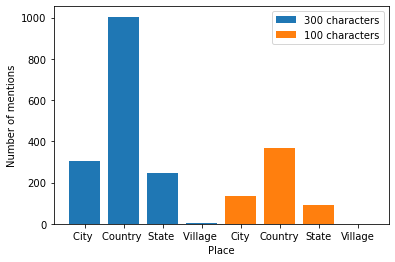

In [37]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.set_ylabel('Number of mentions')
ax1.set_xlabel('Place')

plt.bar(['City ', 'Country ', 'State ', 'Village '], place_number0, label='300 characters')
plt.bar(['City', 'Country', 'State', 'Village'], place_number, label='100 characters')

plt.legend()
plt.savefig('place2.png')

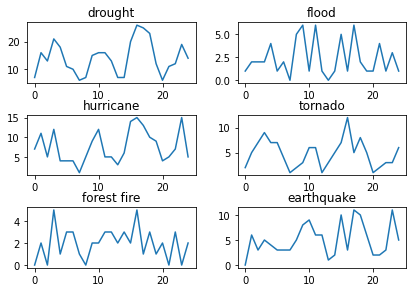

In [68]:
fig, axs = plt.subplots(3, 2, )
plt.tight_layout()

axs[0,0].set_title('drought')
axs[0,0].plot(range(25), results[:,0], label = 'drought')

axs[0,1].set_title('flood')
axs[0,1].plot(range(25), results[:,1], label = 'flood' )

axs[1,0].set_title('hurricane')
axs[1,0].plot(range(25), results[:,2], label = 'hurricane')

axs[1,1].set_title('tornado')
axs[1,1].plot(range(25), results[:,3], label = 'tornado')

axs[2,0].set_title('forest fire')
axs[2,0].plot(range(25), results[:,4], label = 'forest fire')

axs[2,1].set_title('earthquake')
axs[2,1].plot(range(25), results[:,5], label = 'earthquake')
#axs[0,0].plot(range(25), results[:,6], label = 'tsunami')



plt.savefig('disasters.png')

In [ ]:
fig, axs = plt.subplots(3, 2, )
plt.tight_layout()

axs[0,0].set_title('drought')
axs[0,0].plot(range(25), results[:,0], label = 'drought')

axs[0,1].set_title('flood')
axs[0,1].plot(range(25), results[:,1], label = 'flood' )

axs[1,0].set_title('hurricane')
axs[1,0].plot(range(25), results[:,2], label = 'hurricane')

axs[1,1].set_title('tornado')
axs[1,1].plot(range(25), results[:,3], label = 'tornado')

axs[2,0].set_title('forest fire')
axs[2,0].plot(range(25), results[:,4], label = 'forest fire')

axs[2,1].set_title('earthquake')
axs[2,1].plot(range(25), results[:,5], label = 'earthquake')
#axs[0,0].plot(range(25), results[:,6], label = 'tsunami')


In [69]:
axs[0,0]

No handles with labels found to put in legend.


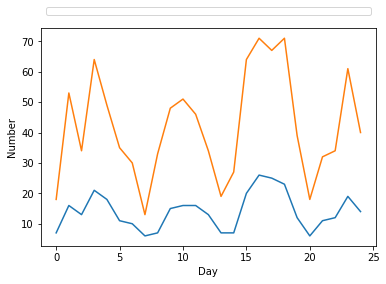

In [41]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.set_ylabel('Number')
ax1.set_xlabel('Day')

plt.plot(range(25), results[:,0])
plt.plot(range(25), results.sum(axis=1))
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), ncol=2, mode="expand")

plt.savefig('vris_vs_novirus.png')

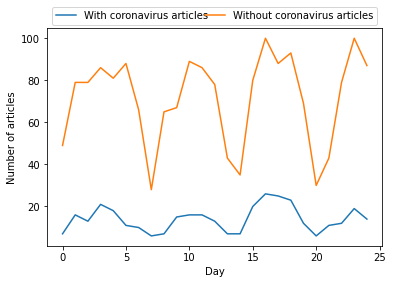

In [90]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.set_ylabel('Number of articles')
ax1.set_xlabel('Day')

plt.plot(range(25), results[:,0], label ='With coronavirus articles')
plt.plot(range(25), results1[:,0], label ='Without coronavirus articles')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), ncol=2, mode="expand")

plt.savefig('vris_vs_novirus.png')